# 2A.i - Huge datasets, datasets hiérarchiques

L'exemple [Building a huge numpy array using pytables](http://stackoverflow.com/questions/8642626/building-a-huge-numpy-array-using-pytables) montre créer une grande matrice qui ne tient pourtant pas en mémoire. Il existe des modules qui permet de faire des calcul à partir de données stockées sur disque comme si elles étaient en mémoire.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## h5py

Le module [h5py](http://www.h5py.org/) est un module qui permet d'agréger un grand nombre de données dans un seul fichier et de les nommer comme des fichiers sur un disque. L'exemple suivant crée un seul fichier contenant deux tableaux :

In [3]:
import h5py
import random
hf = h5py.File('example.hdf5','w')
arr = [ random.randint(0,100) for h in range(0,1000) ]
hf["random/f0_100"] = arr
arr = [ random.randint(0,1000) for h in range(0,10000) ]
hf["random/f0_1000"] = arr
hf.close()

hf = h5py.File('example.hdf5','r')
print(hf)
for k in hf :
    for k2 in hf[k] :
        obj =hf["{0}/{1}".format(k,k2)]
        print(k, k2, obj, obj.value.shape)
hf.close()

<HDF5 file "example.hdf5" (mode r)>
random f0_100 <HDF5 dataset "f0_100": shape (1000,), type "<i4"> (1000,)
random f0_1000 <HDF5 dataset "f0_1000": shape (10000,), type "<i4"> (10000,)


L'avantage est de pouvoir accéder à une partie d'un ensemble sans que celui-ci ne soit chargé en mémoire :

In [4]:
hf = h5py.File('example.hdf5','r')
print(hf["random/f0_1000"][20:25])
hf.close()

[361 155 961 162 560]


## pytables

[pytables](http://pytables.github.io/) peut se comprendre comme une sorte de base de données [sqlite](https://www.sqlite.org/) et [sqlite3](https://docs.python.org/3/library/sqlite3.html) qui s'utilise comme un dataframe.

In [5]:
try:
    from tables import IsDescription, StringCol, Int64Col, Float32Col, Float64Col
except ImportError as e:
    # Parfois cela échoue sur Windows: DLL load failed: La procédure spécifiée est introuvable.
    import sys
    raise ImportError("Cannot import tables.\n" + "\n".join(sys.path)) from e

class Particle(IsDescription):
    name      = StringCol(16)   # 16-character String
    idnumber  = Int64Col()      # Signed 64-bit integer
    pressure  = Float32Col()    # float  (single-precision)
    energy    = Float64Col()    # double (double-precision)

In [6]:
from tables import open_file

h5file = open_file("particule2.h5", mode = "w", title = "Test file")

In [7]:
group = h5file.create_group("/", 'detector', 'Detector information')
table = h5file.create_table(group, 'readout', Particle, "Readout example")
h5file

File(filename=particule2.h5, title='Test file', mode='w', root_uep='/', filters=Filters(complevel=0, shuffle=False, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) 'Test file'
/detector (Group) 'Detector information'
/detector/readout (Table(0,)) 'Readout example'
  description := {
  "energy": Float64Col(shape=(), dflt=0.0, pos=0),
  "idnumber": Int64Col(shape=(), dflt=0, pos=1),
  "name": StringCol(itemsize=16, shape=(), dflt=b'', pos=2),
  "pressure": Float32Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (1820,)

In [8]:
particle = table.row

In [9]:
for i in range(10):
    particle['name']  = 'Particle: %6d' % (i)
    particle['pressure'] = float(i*i)
    particle['energy'] = float(particle['pressure'] ** 4)
    particle['idnumber'] = i * (2 ** 34)
    # Insert a new particle record
    particle.append()

In [10]:
table.flush()

In [11]:
table_read = h5file.root.detector.readout
pressure = [x['pressure'] for x in table_read.iterrows() if 20 <= x['pressure'] < 50]
pressure

[25.0, 36.0, 49.0]

In [12]:
names = [ x['name'] for x in table.where("""(20 <= pressure) & (pressure < 50)""") ]
names

[b'Particle:      5', b'Particle:      6', b'Particle:      7']

Ces lignes sont extraites du [tutoriel](http://www.pytables.org/usersguide/tutorials.html). Le module autorise la création de tableaux, toujours sur disque.

In [13]:
h5file.close()

## blosc

[blosc](http://www.blosc.org/) compresse des tableaux numérique. Cela permet de libérer de la mémoire pendant le temps qu'il ne sont pas utilisés. Il est optimisé pour perdre le moins de temps possible en compression / décompression.

In [14]:
import blosc
import numpy as np

a = np.linspace(0, 100, 10000000)
a.shape

(10000000,)

In [15]:
packed = blosc.pack_array(a)
type(packed), len(packed)

(bytes, 6969171)

In [16]:
array = blosc.unpack_array(packed)
type(array)

numpy.ndarray

In [17]:
%timeit blosc.pack_array(a)

166 ms ± 4.96 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
%timeit blosc.unpack_array(packed)

103 ms ± 6.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Performance en fonction de la dimension.

In [19]:
import time
x = []
t_comp = []
t_dec = []
size = 10
for i in range(1,9):    
    a = np.linspace(0, 100, size)
    t1 = time.perf_counter()
    packed = blosc.pack_array(a)
    t2 = time.perf_counter()
    blosc.unpack_array(packed)
    t3 = time.perf_counter()
    x.append(len(a))
    t_comp.append(t2-t1)
    t_dec.append(t3-t2)
    print(i, t2-t1, t3-t2)
    size *= 10

1 0.019986204999895563 6.755499998689629e-05
2 0.00012523500004135713 3.7926000004517846e-05
3 0.0001631599998290767 4.819800005861907e-05
4 0.0005262239999410667 0.00014814799988016603
5 0.002960992999987866 0.001279211000110081
6 0.018268078000119203 0.011275079999904847
7 0.1547826650000843 0.09316439400004128
8 1.544297945999915 0.9456180869999571


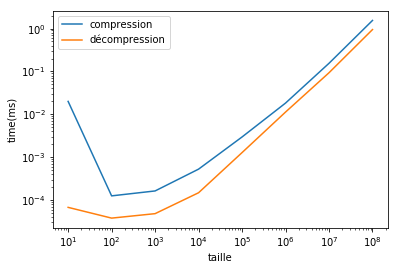

In [20]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
ax.plot(x, t_comp, label="compression")
ax.plot(x, t_dec, label="décompression")
ax.set_xlabel("taille")
ax.set_ylabel("time(ms)")
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')
ax.legend();